# Introduzione

Quello che andiamo a fare in questa esercitazione è il calcolo del raggio medio per l'atomo di idrogeno in due livelli energetici diversi, 1s e 2p. Per farlo, dobbiamo calcolare il seguente integrale:

$$\langle r \rangle  \equiv \int_0^\infty r\, \Psi(r,\theta,\phi)\, r^2 \sin(\theta) \mathrm d r \, \mathrm d \theta\, \mathrm d \phi$$

Per calcolare questo integrale sfruttiamo l'approssimazione Monte Carlo. Essa consiste nell'approssimare l'integrale come una somma discreta in cui la funzione integranda viene valutata in $N$ punti estratti casualmente a partire dalla distribuzione di probabilità $\Psi$:

$$\begin{aligned}
\langle r \rangle & \equiv \int_0^\infty r\, \Psi(r,\theta,\phi)\, r^2 \sin(\theta) \mathrm d r \mathrm d \theta \mathrm d \phi\\ 
&= \int_0^\infty dx \int _0 ^\infty dy \int_0^\infty dz \sqrt{x^2+y^2+z^2} \, \Psi(x,y,z) \\
& \approx \frac{1}{N} \sum_{i=1}^N \sqrt{x_i^2+y_i^2+z_i^2}
\end{aligned}$$

dove $x_i$ sono dei numeri random con distribuzione $\Psi$. Per generare gli $x_i$ utilizziamo l'algoritmo di Metropolis che si basa sulla creazione di una catena di Markov in cui la distribuzione dei passi si avvicini maggiormente alla distribuzione desiderata. 

<img src="https://www.researchgate.net/publication/279248766/figure/fig1/AS:398167716712448@1471941989696/Flowchart-of-Metropolis-Hastings-M-H-algorithm-for-the-parameter-estimation-using-the.png" alt="alt text" title="image Title" width="500"/>

In particolare, a partire da una configurazione iniziale il sistema viene fatto evolvere seguendo una catena di Markov nello spazio delle configurazioni con matrice di transizione:
$$K(\vec x| \vec y) = T(\vec x|\vec y) \cdot A(\vec x| \vec y) = T(\vec x|\vec y) \cdot \min\left[1, \frac{T(\vec y| \vec x)p(\vec x)}{T(\vec x| \vec y)p( \vec y)}\right] = T(\vec x| \vec y)\cdot \min \left[1, \frac{p(\vec x)}{p( \vec y)} \right].$$
Nel nostro caso specifico, la probabilità condizionata $T(x|y)$ è una distribuzione uniforme centrata nell'intorno del punto attuale $x_{i+1}=[x_i-\delta, x_i+\delta].$ Invece la distribuzione di accettazione $A(x|y)$ è data dal rapporto fra le due stime della funzione $\Psi$:
$$A(x|y)=\min \left[ 1, \frac{\Psi(r_{i+1})}{\Psi(r_i)}\right]$$

Quello che ora ci proponiamo di fare è studiare l'algoritmo e la sua efficacia al variare dei principali parametri: 
* **Punto di partenza** del random walk. Infatti quello che ci aspettiamo è che nel caso in cui partiamo dalle code della distribuzione, sia richiesto un tempo di equilibrazione prima di raggiungere le zone a più alta densità. 
* **Dimensione dei blocchi**. Infatti per rientrare nelle ipotesi del TLC è necessario che i blocchi siano indipendenti. Studiamo quindi la funzione di autocorrelazione per capire quale sia la lunghezza di correlazione caratteristica. 
* **Distribuzione dei passi**. Usiamo dapprima una distribuzione dei passi uniforme e poi una gaussiana ed osserviamo come cambiano le proprietà di convergenza dell'algoritmo.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import string
from scipy.optimize import curve_fit
import scipy
from scipy.special import erf
from scipy import log, exp, sqrt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stat
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D

sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

# 1. Punto di partenza

Consideriamo ora due simulazioni in cui partiamo dall'origine e da un punto $(30,30,30)$. Vediamo come varia il tempo di equilibrazione nei due casi:

In [2]:
path ='Exercises_05.1/'

path_1 = np.loadtxt(path+"file_path_1.txt")
path_2 = np.loadtxt(path+ "file_path_2.txt")

path_1_no_origin = np.loadtxt(path+"file_path_1_no_origin.txt")
path_2_no_origin = np.loadtxt(path+"file_path_2_no_origin.txt")

n_step = np.shape(path_1)[0]

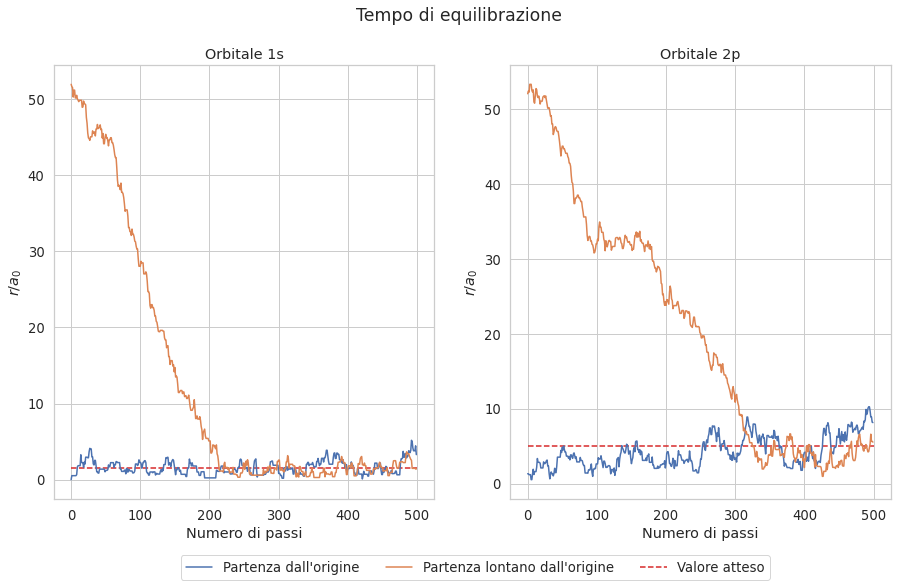

In [3]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(15, 8))

fig.suptitle('Tempo di equilibrazione')

ax1.plot(
    path_1[:500],
    label= "Partenza dall'origine"
);
ax1.plot(
    path_1_no_origin[:500],
    label= "Partenza lontano dall'origine"
);


ax1.hlines(1.5, 0, 500, color=plt.cm.tab10(3),linestyle='--', label='Valore atteso');

ax1.set_title('Orbitale 1s')
ax1.set_xlabel('Numero di passi')
ax1.set_ylabel(r'$r/a_0$')

ax1.legend(bbox_to_anchor=(1.9,-0.2), loc="lower right", ncol=3)



ax2.plot(
    path_2[:500]
);
ax2.plot(
    path_2_no_origin[:500]
);

ax2.hlines(5, 0, 500, color=plt.cm.tab10(3),linestyle='--', label='Valore atteso');
ax2.set_title('Orbitale 2p')
ax2.set_xlabel('Numero di passi')
ax2.set_ylabel(r'$r/a_0$');

>Questo grafico ci consente di apprezzare il fatto che, per entrambi gli orbitali, qualora si consideri come punto iniziale un punto che giace nelle code della distribuzione, allora si ha un tempo di equilibrazione. 

# Dimensione dei blocchi

Studiamo ora quale sia la lunghezza di correlazione fra i diversi passi dell'algoritmo di Metropolis. Per farlo calcoliamo la funzione di autocorrelazione. Confermiamo il risultato ottenuto attraverso la verifica del TLC.

In [4]:
def exp_fit(x, t_0):
    return np.exp(-x / t_0)

x= np.linspace(0,n_step,n_step)

popt, pcov = curve_fit(exp_fit, x,sm.tsa.acf(path_1,nlags=n_step, fft=True))
popt2, pcov2 = curve_fit(exp_fit, x,sm.tsa.acf(path_2,nlags=n_step, fft=True))

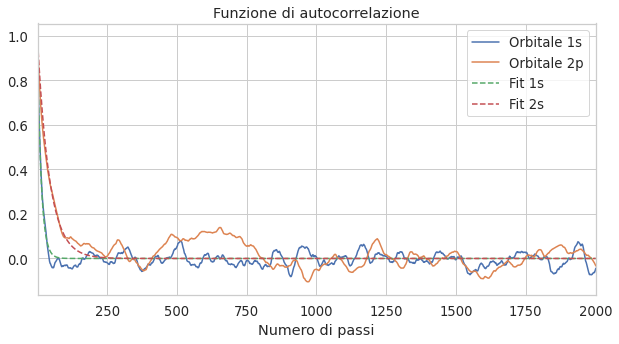

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

ax.plot(sm.tsa.acf(path_1,nlags=n_step, fft=True),label='Orbitale 1s')
ax.plot(sm.tsa.acf(path_2,nlags=n_step,fft=True), label='Orbitale 2p')
ax.plot(x, exp_fit(x, *popt),linestyle = '--', label='Fit 1s')
ax.plot(x, exp_fit(x, *popt2), linestyle = '--', label='Fit 2s')

#ax.set_xscale('log')
ax.set_xlim(1,2000);
ax.set_xlabel('Numero di passi')
ax.set_title('Funzione di autocorrelazione');
ax.legend(loc='best');

Per entrambi gli orbitali, osserviamo che la funzione di correlazione decade a zero dopo circa 100 passi. Tuttavia per avere un'informazione più quantitativa, fittiamo le due curve con un modello esponenziale e ricaviamo il tempo tipico $t_0$ di correlazione. In particolare otteniamo che: 

In [6]:
print("[1s] Autocorrelation length: "+ str(popt[0]) + " +- " + str(np.sqrt(np.diag(pcov))[0]))
print("[2p] Autocorrelation length: "+ str(popt2[0]) + " +- " + str(np.sqrt(np.diag(pcov2))[0]))

[1s] Autocorrelation length: 13.480058120926117 +- 0.18333061206685936
[2p] Autocorrelation length: 42.746300145807126 +- 0.5753708589476562


Infine valutiamo la bontà del risultato ottenuto andando a verificare la validità del TLC per blocchi con una lunghezza variabile. Effettuiamo questa verifica solo per l'orbitale 1s:

Text(0, 0.5, 'Densità di probabilità')

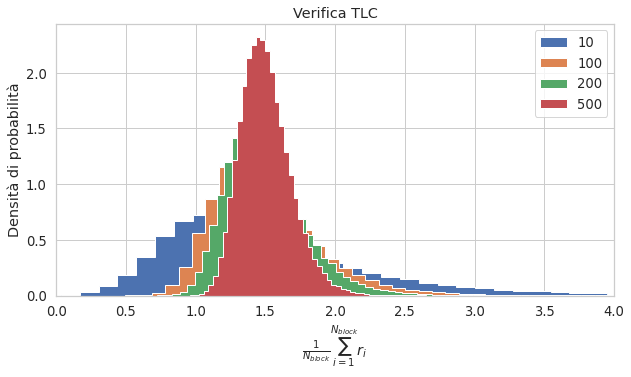

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))


for i in [10,100,200,500]:
    N_block = np.loadtxt(path+"file_N_block_"+str(i)+".txt")
    ax.hist(N_block, bins=60,label=str(i), histtype='stepfilled',density=True)
    ax.set_xlim(0,4)
    
ax.legend()
ax.set_title("Verifica TLC")
ax.set_xlabel(r"$\frac{1}{N_{block}}\sum_{i=1}^{N_{block}}r_i$");
ax.set_ylabel('Densità di probabilità')

>Osserviamo che per blocchi della lunghezza i 200 passi si osservano ancora code poco gaussiane. Questo ci spinge a considerare blocchi di 500 passi per il resto della trattazione.

# Valor medio 

Calcoliamo ora il valor medio del raggio. Addottiamo come sempre una procedura a blocchi. In particolare scegliamo la dimensione dei blocchi pari a 500 passi così da essere sufficientemente sicuri di avere blocchi indipendenti.

In [8]:
mean_r_1, std_r_1 = np.loadtxt(path+"file_mean_r_1.txt",delimiter = ",", unpack = True)
mean_r_2, std_r_2 = np.loadtxt(path+"file_mean_r_2.txt",delimiter = ",", unpack = True)

Text(0.5, 1.0, 'Orbitale 2p')

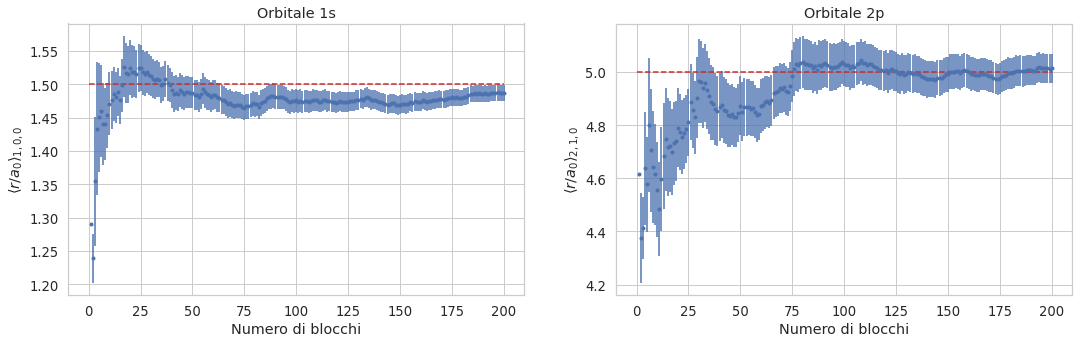

In [9]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(18,5)); 

ax1.errorbar(
    np.arange(1,np.size(mean_r_1)+1,1),
    mean_r_1,
    yerr = std_r_1,  
    marker='.', linestyle="", label='Metodo diretto'
);


ax1.hlines(1.5, 0, 200, color=plt.cm.tab10(3),linestyle='--', label='Valore atteso');
ax1.grid(':')
ax1.set_xlabel('Numero di blocchi')
ax1.set_ylabel(r'$\langle r/a_0 \rangle_{1,0,0} $')
ax1.set_title('Orbitale 1s')

ax2.errorbar(
    np.arange(1,np.size(mean_r_1)+1,1),
    mean_r_2,
    yerr = std_r_2,  
    marker='.', linestyle="", label='Metodo diretto'
);


ax2.hlines(5, 0, 200, color=plt.cm.tab10(3),linestyle='--', label='Valore atteso');

ax2.grid(':')
ax2.set_xlabel('Numero di blocchi')
ax2.set_ylabel(r'$\langle r/a_0 \rangle_{2,1,0}$')
ax2.set_title('Orbitale 2p')

> Osserviamo che per entrambi gli orbitali, la valutazione del valor medio del raggio converge al valore atteso entro 2$\sigma$.

# Rappresentazione grafica

Visualizziamo ora la densità di probabilità dei due orbitali in 3D:

In [10]:
x_1, y_1, z_1 = np.loadtxt(path+"file_points_1.txt",delimiter = ",", unpack = True)
x_2, y_2, z_2 = np.loadtxt(path+"file_points_2.txt",delimiter = ",", unpack = True)

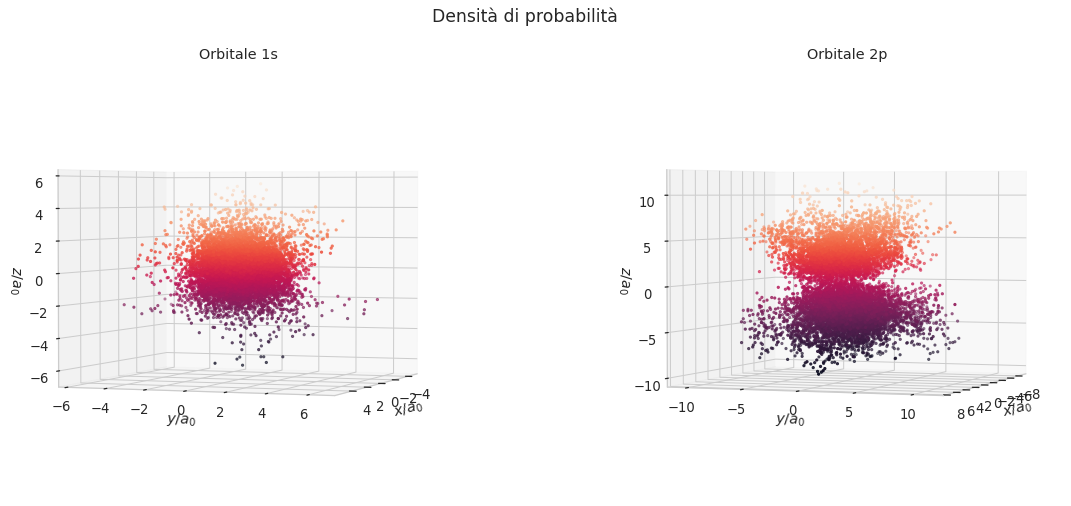

In [16]:
fig = plt.figure(figsize = (20,8))
fig.suptitle('Densità di probabilità')

ax = fig.add_subplot(1, 2, 1,  projection = "3d")
ax.scatter(x_1, y_1, z_1, c=z_1, marker='.')
ax.set_xlabel(r'$x/a_0$')
ax.set_ylabel(r'$y/a_0$')
ax.set_zlabel(r'$z/a_0$')
ax.set_title('Orbitale 1s')
ax.view_init(2, 20)
ax.grid(':')

ax = fig.add_subplot(1, 2, 2, projection = "3d")
ax.scatter(x_2, y_2, z_2, c=z_2, marker='.')
ax.set_xlabel(r'$x/a_0$')
ax.set_ylabel(r'$y/a_0$')
ax.set_zlabel(r'$z/a_0$')
ax.set_title('Orbitale 2p')
ax.view_init(2, 20)
ax.grid(':')

plt.show()

>Il risultato ottenuto corrisponde a quello atteso 

# Distribuzione degli spostamenti gaussiana

Valutiamo ora cosa cambia quando al posto di considerare una distribuzione uniforme per gli spostamenti consideriamo una distribuzione normale. In particolare scegliamo una gaussiana con $\mu = 0$ e deviazione standard $\sigma = 0.7 a_0$. La scelta della deviazione standard è sempre associata al fatto di avere una percentuale di accettazione pari al 50%. 

In questo caso non abbiamo mostrato le stesse analisi del tempo di equilibrazione e della lunghezza di correlazione, tuttavia i parametri scelti in precedenza erano ottimali anche in questo caso. 

In [12]:
mean_norm_r_1, std_norm_r_1 = np.loadtxt(path+"file_mean_norm_r_1.txt",delimiter = ",", unpack = True)
mean_norm_r_2, std_norm_r_2 = np.loadtxt(path+"file_mean_norm_r_2.txt",delimiter = ",", unpack = True)

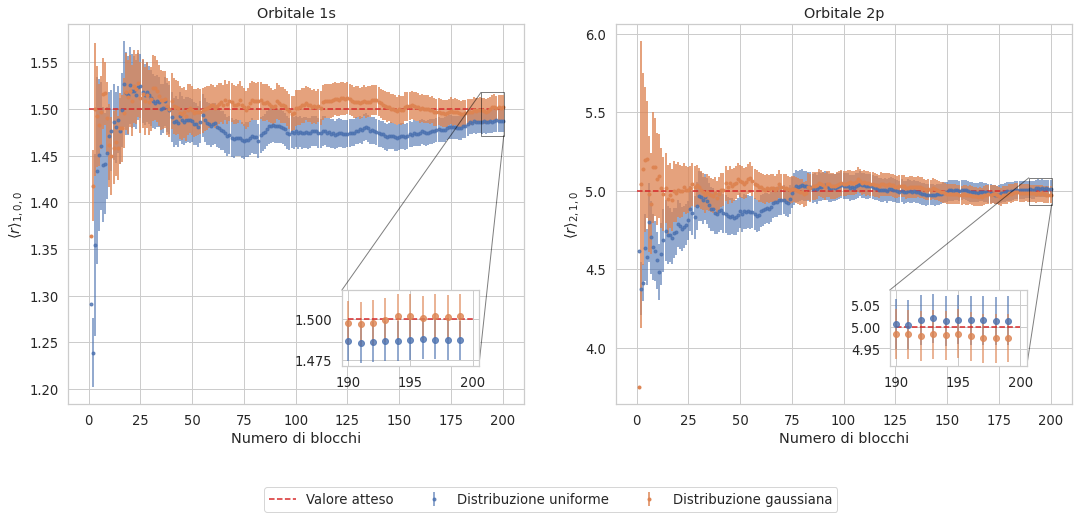

In [33]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(18,7)); 

ax1.errorbar(
    np.arange(1,np.size(mean_r_1)+1,1),
    mean_r_1,
    yerr = std_r_1,  
    marker='.', linestyle="",  alpha=0.8
);

ax1.errorbar(
    np.arange(1,np.size(mean_r_1)+1,1),
    mean_norm_r_1,
    yerr = std_norm_r_1,  
    marker='.', linestyle="", label='Metodo diretto'
);
ax1.grid(':')

ax1.hlines(1.5, 0, 200, color=plt.cm.tab10(3),linestyle='--', label='Valore atteso');
ax1.grid(':')
ax1.set_xlabel('Numero di blocchi')
ax1.set_ylabel(r'$\langle r \rangle_{1,0,0}$')
ax1.set_title('Orbitale 1s');

ax3 = ax1.inset_axes([0.6, 0.1, 0.30, 0.20])


ax3.errorbar(
    np.arange(190, 200,1),
    mean_r_1[190:],
    yerr = std_r_1[190:],  
    marker='o', linestyle="", label='Distribuzione uniforme', alpha=0.8
);

ax3.errorbar(
    np.arange(190, 200,1),
    mean_norm_r_1[190:],
    yerr = std_norm_r_1[190:],  
    marker='o', linestyle="", label='Distribuzione gaussiana', alpha=0.8
);
ax3.hlines(1.5, 190, 200, color=plt.cm.tab10(3),linestyle='--', label='Valore atteso');

ax1.indicate_inset_zoom(ax3, edgecolor="black")

ax2.errorbar(
    np.arange(1,np.size(mean_r_1)+1,1),
    mean_r_2,
    yerr = std_r_2,  
    marker='.', linestyle="", label='Distribuzione uniforme', alpha=0.8
);


ax2.errorbar(
    np.arange(1,np.size(mean_r_1)+1,1),
    mean_norm_r_2,
    yerr = std_norm_r_2,  
    marker='.', linestyle="", label='Distribuzione gaussiana'
);


ax2.hlines(5, 0, 200, color=plt.cm.tab10(3),linestyle='--', label='Valore atteso');


ax4 = ax2.inset_axes([0.6, 0.1, 0.30, 0.20])


ax4.errorbar(
    np.arange(190, 200,1),
    mean_r_2[190:],
    yerr = std_r_2[190:],  
    marker='o', linestyle="", label='Distribuzione uniforme', alpha=0.8
);

ax4.errorbar(
    np.arange(190, 200,1),
    mean_norm_r_2[190:],
    yerr = std_norm_r_2[190:],  
    marker='o', linestyle="", label='Distribuzione gaussiana', alpha=0.8
);
ax4.hlines(5, 190, 200, color=plt.cm.tab10(3),linestyle='--', label='Valore atteso');

ax2.indicate_inset_zoom(ax4, edgecolor="black",label='')

ax2.legend(bbox_to_anchor=(0.5,-0.3), loc="lower right", ncol=3)
ax2.grid(':')
ax2.set_xlabel('Numero di blocchi')
ax2.set_ylabel(r'$\langle r \rangle_{2,1,0}$')
ax2.set_title('Orbitale 2p');

> Da questa analisi non sembrano emergere particolari differenze fra le due distribuzioni. 